
# Applied Machine Learning Days EPFL 2022 - Workshop on<br>**Visual Disinformation and the Dark Side of Internet Memes**<br>Part 2

We will analyse data from Twitter that were identified as state linked information operations (see [Link](https://transparency.twitter.com/en/reports/information-operations.html)). Specifically, we will look into data from the GRU, disseminated by 69 Twitter accounts.

The **goal** is to use cross-modal representations from the [CLIP model](https://openai.com/blog/clip/) for the analysis of the images used in the Tweets.



## Preparations

We get our data and install necessary dependencies. This may take a minute.

In [ ]:
# Set Data Path - You can change this for local setups
import os
DATA_ROOT_PATH='/content/data'
os.environ["DATA_ROOT_PATH"] = DATA_ROOT_PATH

In [ ]:
!mkdir {DATA_ROOT_PATH}
!wget https://github.com/i4Ds/AMLD-2022-Visual-Disinformation/raw/main/data/GRU_202012.tar.gz -P {DATA_ROOT_PATH}/

In [ ]:
!tar -xf {DATA_ROOT_PATH}/GRU_202012.tar.gz --directory {DATA_ROOT_PATH}/

In [ ]:
!pip install transformers

## Imports & Settings

In [ ]:
import itertools
from pathlib import Path
from typing import List, Union, Optional

from IPython.core.display import display, HTML
import ipywidgets as widgets
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
from transformers import CLIPModel, CLIPProcessor

## Load Data

In [ ]:
# Load Tweets
campaign_id = 'GRU_202012'
data_path = Path(DATA_ROOT_PATH)
data_path = data_path.joinpath(campaign_id)
df_tweets = pd.read_csv(data_path.joinpath("tweets.csv"), dtype=str)

print(f"Loaded: {df_tweets.shape[0]} Tweets")

In [ ]:
# Loading CLIP (pre-computed) features
clip_pre_computed_features_path = data_path.joinpath('clip_features')
clip_feature_files = [x for x in clip_pre_computed_features_path.glob("*.pt")]
clip_feature_files.sort()

with torch.no_grad():
    batch_data = [torch.load(f) for f in clip_feature_files]
    clip_features = torch.cat([b['image_features'] for b in batch_data])

print(f"Loaded {clip_features.shape[0]} CLIP Features")

In [ ]:
# Arrange and combine Tweet and CLIP feature data

clip_paths = list(
    itertools.chain.from_iterable([b['image_paths'] for b in batch_data]))
tweet_ids = list(
    itertools.chain.from_iterable([b['ids'] for b in batch_data]))

df_clip_paths = pd.DataFrame(
    {'path_image': clip_paths,
     'campaign_id': campaign_id,
     'tweetid': tweet_ids})

df_ml = (
    df_clip_paths
    .set_index('tweetid')
    .join(df_tweets.set_index('tweetid')[['tweet_text']], how='inner')
    .assign(
        path_image_abs=lambda df: [data_path.joinpath(x) for x in df.path_image]
        )
)

df_ml = pd.merge(
    left=df_clip_paths,
    right=df_ml.reset_index(),
    on=['tweetid', 'path_image', 'campaign_id'],
    how='left')

assert df_ml.shape[0] == clip_features.shape[0], "feature / records missmatch"
assert list(df_ml.tweetid) == list(df_clip_paths.tweetid), "sort missmatch"

data = {'info': df_ml, 'clip_features': clip_features}
print(f"Created Data Dictionary with {data['info'].shape[0]} entries")


In [ ]:
# Display Data Dictionary - First 3 entries
data['info'].head(3)

## Prepare CLIP Model

We use the HuggingFace (https://huggingface.co/) 'transformer' module to load the CLIP model.

In [ ]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

## Define Functions

### Visualisation

The following functions help us display the data.

In [ ]:
#@title Visualisation Functions
def display_tweet(df: pd.DataFrame, idx: int) -> None:
    html = get_tweet_as_html(df, idx)
    display(HTML(html))


def get_tweet_as_html(df: pd.DataFrame, idx: int) -> str:
    row = df.iloc[idx]
    image = Image.open(row.path_image_abs)
    html = create_tweet_as_html(
        row.tweet_text, 
        image,
        {'tweetid': row.tweetid,
         'campaign_id': row.campaign_id})
    return html


def create_tweet_as_html(
      text:str ,
      image: Image.Image,
      meta_data:  Optional[dict]=None) -> str:
    """ Embedd text and image in html code """
    from io import BytesIO
    from base64 import b64encode
    b = BytesIO()  
    
    image.save(b, format='png')

    if meta_data:
        meta_str = ', '.join([f"{k}: {v}" for k, v in meta_data.items()])
        meta_str = f"({meta_str})"
    else:
        meta_str = ''
    html = (
    '<head>'
    '<meta charset="UTF-8">'
    '<style>'
      'img.tweet_image {'
        'border-radius: 15px;'
        'width: 600px;'
      '}'
      'div.tweet {'
        'max-width: 600px;'
       '}'
    '</style>'
    '</head>'
    '<body>'
        '<div class="tweet">'
        f"<b style='font-size:1.25em'>{text}</b>"
         "<figcaption> </figcaption>"
        f'<img class="tweet_image", src="data:image/png;base64,{b64encode(b.getvalue()).decode("utf-8")}">'
        f"<b style='font-size:0.8em'>{meta_str}</b>"
        '</div>'
    '</body>')
    return html


def get_nearest_observations_to_centroid(x, centroid):
    distance = np.sqrt(np.sum((x - np.array([centroid])) ** 2, axis=1))
    idx = np.argsort(distance)
    return idx
    

def display_cluster(df, x, centroid, max_to_display=50):
    idx = get_nearest_observations_to_centroid(x, centroid)
    
    idx = idx[0:max_to_display]
    idx_selector = widgets.Select(
        options=[x for x in idx],
        description='Indices',
        disabled=False,
    )
    # Display one example to notebook output
    _ = widgets.interact(
        display_tweet,
        idx=idx_selector,
        df=widgets.fixed(df))


### CLIP Functions

In [ ]:
#@title CLIP specific functions
def create_clip_embeddigs_from_text(
      model,
      texts: Union[List[str], str]) -> torch.Tensor:
    """ Creates CLIP embeddings from a list of strings
        Args: 
            model: the CLIP model instance
            texts: a list of strings or a single string to convert to embeddings
        Returns:
            a tensor of shape (num_texts, 512) with the embeddings
    """
    text_embedding = processor(
        text=texts,
        padding='max_length',
        truncation=True,
        return_tensors="pt")
    with torch.no_grad():
        text_features = model.get_text_features(
            input_ids=text_embedding['input_ids'])
    return text_features


def clip_projection(
      x: torch.Tensor,
      y1: torch.Tensor,
      y2: torch.Tensor) -> torch.Tensor:
    """ Project observations x onto difference vector y1 - y2
        Args: 
            x: shape (N_INPUTS, N_FEATURES), observations to project
            y1 / y2: shape (1, N_FEATURES), start/end points
        Returns:
            tensor of shape (N_INPUTS, 1) with scores
    """
    x /= x.norm(dim=-1, keepdim=True)
    y1 /= y1.norm(dim=-1, keepdim=True)
    y2 /= y2.norm(dim=-1, keepdim=True)
    diff = y1 - y2
    return x.matmul(diff.T)


## Dataset Visualisation

Machine learning projects always start with data inspection. We are going to visually inspect some of the Tweets to get an idea of what we can expect.

The following code let's you browse through the Tweets. Select different observations using the **drop-down menu**.

In [ ]:
idx_selector = widgets.Select(
    options=np.linspace(0, data['info'].shape[0]-1, 40).astype(int),
    description='Indices',
    disabled=False
)

_ = widgets.interact(
    display_tweet, idx=idx_selector,
    df=widgets.fixed(data['info']))

## Image Retrieval

The goal of this task is to find relevant images using the cross-modal embedding space of the CLIP model. We construct a text query and then compare its embedding to all the embeddings of the images in our dataset using dot products. We then select the k images with the largest values of the dot product.

Study the following figure to understand what we are trying to do.

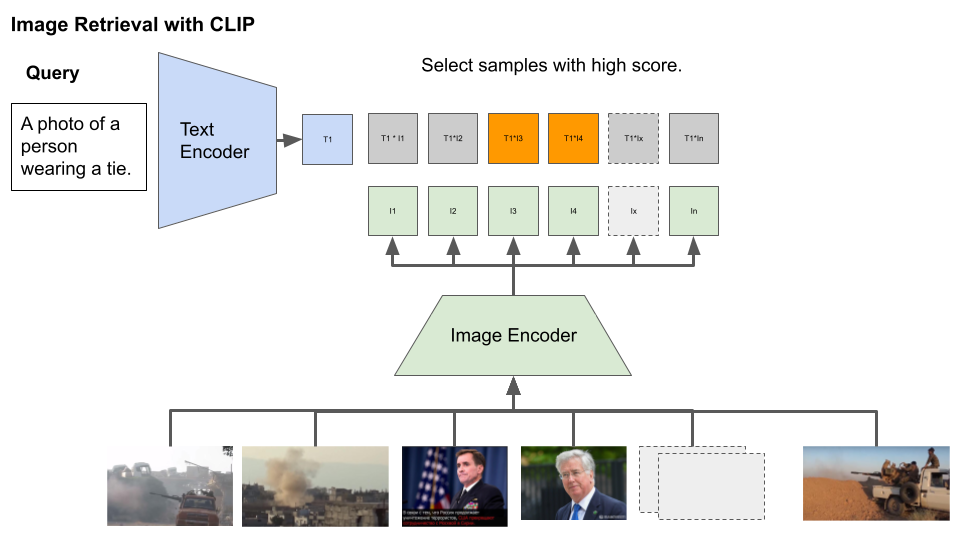

Complete the following function to calculate dot products between query and all images:

In [ ]:
def clip_similarity(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """ Calculate similarities of each observation x to target y
        Args: 
            x: tensor of shape (N_INPUTS, N_FEATURES)
            y: tensor of shape (1, N_FEATURES)
        Returns:
            tensor of shape (N_INPUTS, 1) with similarities
    """
    x /= x.norm(dim=-1, keepdim=True)
    y /= y.norm(dim=-1, keepdim=True)
    
    # TODO: Complete code, take a look at the 'return' shape and type

In [ ]:
#@title Show Solution














def clip_similarity(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """ Calculate similarities of each observation x to target y
        Args: 
            x: tensor of shape (N_INPUTS, N_FEATURES)
            y: tensor of shape (1, N_FEATURES)
        Returns:
            tensor of shape (N_INPUTS, 1) with similarities
    """
    x /= x.norm(dim=-1, keepdim=True)
    y /= y.norm(dim=-1, keepdim=True)
    return x.matmul(y.T)

Create a query to find photos of war planes.

In [ ]:
query = "A photo of a war plane"

In [ ]:
clip_query_embedding = create_clip_embeddigs_from_text(model, query)
similarity = clip_similarity(
    data['clip_features'],
    clip_query_embedding).numpy()
  
sorted_indices = np.argsort(similarity[:, 0])[-20:]
idx_selector = widgets.Select(
    options=[x for x in sorted_indices],
    description='Indices',
    disabled=False
)
_ = widgets.interact(
    display_tweet, idx=idx_selector,
    df=widgets.fixed(data['info']))

Create other, possibly more complex queries. 

In [ ]:
query = ""

clip_query_embedding = create_clip_embeddigs_from_text(model, query)
similarity = clip_similarity(
    data['clip_features'],
    clip_query_embedding).numpy()
  
sorted_indices = np.argsort(similarity[:, 0])[-20:]
idx_selector = widgets.Select(
    options=[x for x in sorted_indices],
    description='Indices',
    disabled=False
)
_ = widgets.interact(
    display_tweet, idx=idx_selector,
    df=widgets.fixed(data['info']))

How good is the image retrieval? Discuss your impression in the following cell.

## Zero-Shot Classification

In the following we will use CLIP for zero-shot learning. Meaning: We will define a set of classes of interest and calculate relative similarities for each image with respect to the different classes (sum over all classes is 1). This will assign each image to one of the classes (the one with the highest score).

Study the following figure to understand what we are trying to do.

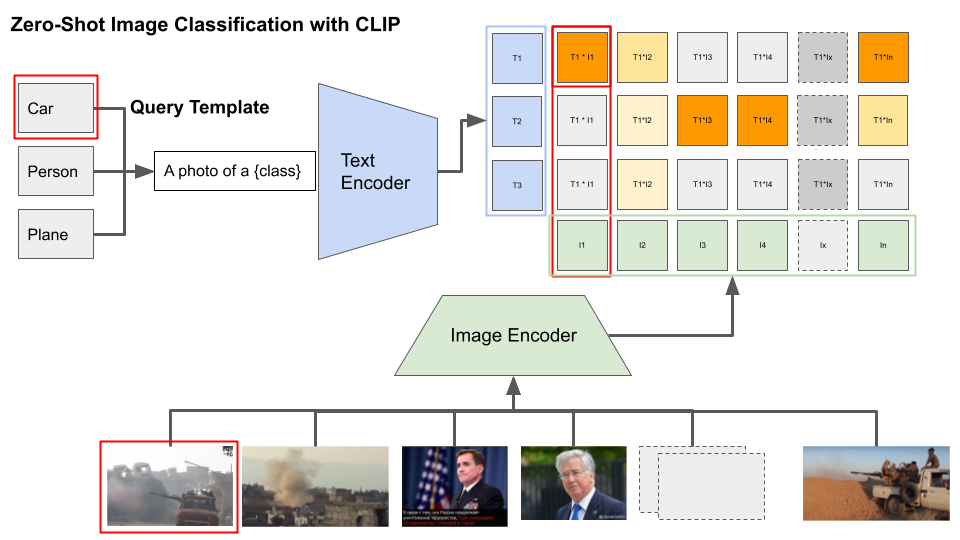

Create a zero-shot classifier to distingish between different types of media. Create fitting queries to identify: photographs, memes and documents. Use this order when creating the queries.

First, finish the following function to calculate class probabilities:

In [ ]:
def clip_classifier(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """ Calculate class probabilities of each observation x to all classes y
        Args: 
            x: tensor of shape (N_INPUTS, N_FEATURES)
            y: tensor of shape (N_CLASSES, N_FEATURES)
        Returns:
            tensor of shape (N_INPUTS, N_CLASSES) with class probabilities
    """
    x /= x.norm(dim=-1, keepdim=True)
    y /= y.norm(dim=-1, keepdim=True)
    # TODO: calculate the appropriate matrix multiplication and use
    # the softmax transformation to calculate class probabilities
    # see (https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html)
    # take a look at the 'return' shape and type

In [ ]:
#@title Solution
def clip_classifier(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    """ Calculate class probabilities of each observation x to all classes y
        Args: 
            x: tensor of shape (N_INPUTS, N_FEATURES)
            y: tensor of shape (N_CLASSES, N_FEATURES)
        Returns:
            tensor of shape (N_INPUTS, N_CLASSES) with class probabilities
    """
    x /= x.norm(dim=-1, keepdim=True)
    y /= y.norm(dim=-1, keepdim=True)
    probs = (x @ y.T).softmax(dim=-1)
    return probs

Define the queries that represent the different classes in textual form, similar to the image retrieval task.

In [ ]:
# TODO: build different queries for the different classes
queries = [
    "",
    "",
    ""
]


In [ ]:
#@title Show a Solution
queries = [
    "This is a photograph",
    "This is a meme",
    "This is a document"
]

In [ ]:
clip_query_embeddings = create_clip_embeddigs_from_text(model, queries)
similarity = clip_classifier(
    data['clip_features'],
    clip_query_embeddings).numpy()

Now we are displaying the examples most associate with the "photograph" class. Note that the index in `similarity[:, 0]` refers to the first class as defined in the `queries` list.

In [ ]:
sorted_indices = np.argsort(similarity[:, 0])[-20:]
idx_selector = widgets.Select(
    options=[x for x in sorted_indices],
    description='Indices',
    disabled=False
)
_ = widgets.interact(
    display_tweet, idx=idx_selector,
    df=widgets.fixed(data['info']))

Lets look at examples of "memes":

In [ ]:
sorted_indices = np.argsort(similarity[:, 1])[-20:]
idx_selector = widgets.Select(
    options=[x for x in sorted_indices],
    description='Indices',
    disabled=False
)
_ = widgets.interact(
    display_tweet, idx=idx_selector,
    df=widgets.fixed(data['info']))

And finally: let's take a look at the "document" class.

In [ ]:
sorted_indices = np.argsort(similarity[:, 2])[-20:]
idx_selector = widgets.Select(
    options=[x for x in sorted_indices],
    description='Indices',
    disabled=False
)
_ = widgets.interact(
    display_tweet, idx=idx_selector,
    df=widgets.fixed(data['info']))

- What is your impression of the classifier? 
- What happens if the classes are not exhaustive? I.e. if some images do not belong to any of the defined classes?

Discuss in the next cell.

## Emotion Analysis

Next, we are going to investigate if we can characterize images from these tweets along certain emotions that they might induce in a viewer of these images. Inciting strong emotions may be a goal of disinformation.

The approach is very similar to zero-shot learning with the difference that we don't normalize the scores to produce class probabilities.

Study the following figure to understand what we are trying to do.

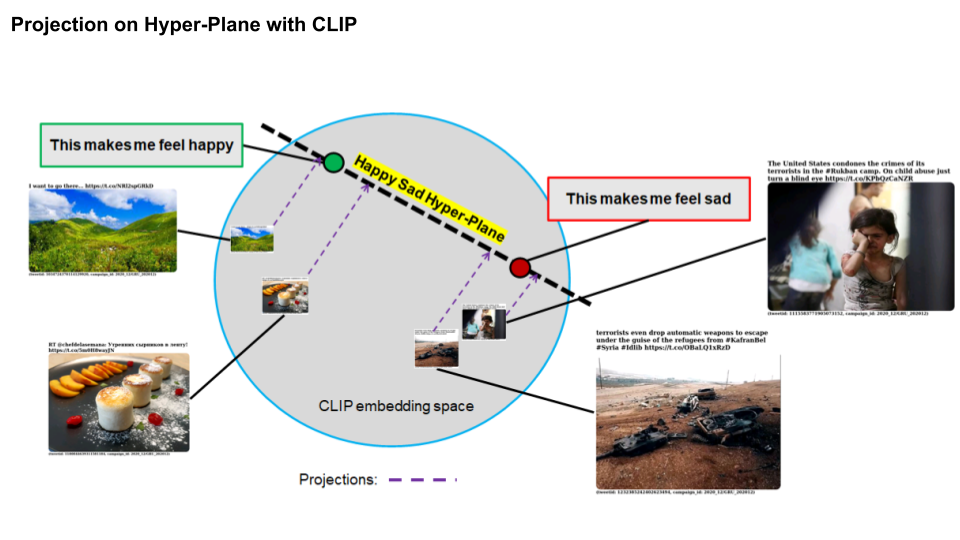

Create prompts using a [list comprehension](https://www.w3schools.com/python/python_lists_comprehension.asp). Complete the following code:

In [ ]:
emotions = ["happy", "sad"]
# Create a list of queries using a Python list comprehension
queries = ...


Click below for a solution.

In [ ]:
#@title Show a solution
emotions = ["happy", "sad"]
queries = [f"This makes me feel {x}" for x in emotions]

In [ ]:
clip_text_embeddings = create_clip_embeddigs_from_text(model, queries)

emotion_score = clip_projection(
    x=data['clip_features'],
    y1=clip_text_embeddings[0:1, :],
    y2=clip_text_embeddings[1:, :]).numpy()

The following figure shows the distribution of the scores.

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
_ = sns.histplot(emotion_score, ax=ax, kde='density', legend=False).set(
    title=f"Projection of Images on {emotions[0]} -> {emotions[1]}",
    xlabel=f"{emotions[0]} score")

### Display Happy Examples

In [ ]:
sorted_indices = np.argsort(emotion_score[:, 0])[-20:]
idx_selector = widgets.Select(
    options=[x for x in sorted_indices],
    description='Indices',
    disabled=False
)

In [ ]:
_ = widgets.interact(
    display_tweet, idx=idx_selector,
    df=widgets.fixed(data['info']))

### Display Sad Examples

In [ ]:
sorted_indices = np.argsort(emotion_score[:, 0])[:20]
idx_selector = widgets.Select(
    options=[x for x in sorted_indices],
    description='Indices',
    disabled=False
)

In [ ]:
_ = widgets.interact(
    display_tweet, idx=idx_selector,
    df=widgets.fixed(data['info']))

Would you say that CLIP embeddings contain information about emotions? Discuss in the next cell.

### Optional Task: Inspect images with a neutral score.

In [ ]:
# TODO show neutral samples

In [ ]:
#@title Solution
sorted_indices = np.argsort(np.abs(emotion_score[:, 0]))[0:20]
idx_selector = widgets.Select(
    options=[x for x in sorted_indices],
    description='Indices',
    disabled=False
)
_ = widgets.interact(
    display_tweet, idx=idx_selector,
    df=widgets.fixed(data['info']))

## Dimensionality Reduction

In the following, we are going to reduce the dimensionality of the CLIP embeddings (512-D) to 2-D in order to visualize the whole dataset as a point cloud. We might see some structure. We are going to use [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) and [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) for the dimensionality reduction. 

Study the following figure to understand what we are trying to do.

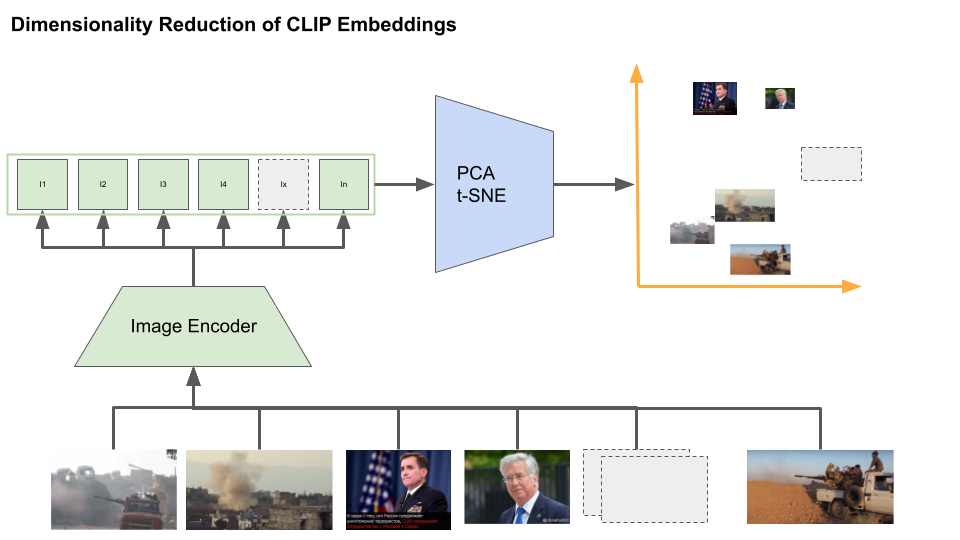

In [ ]:
# Reduction to 50 dimensions with PCA
pca = PCA(n_components=50, random_state=123)
x_pca = pca.fit_transform(data['clip_features'].numpy())

In [ ]:
# Reduction from 50 dimensions to 2 dimensions
tsne = TSNE(n_components=2, random_state=123, init='random', learning_rate='auto')
x_tsne = tsne.fit_transform(x_pca)

In [ ]:
df_dim_red = pd.DataFrame(
    {'dim1': x_tsne[:, 0],
     'dim2': x_tsne[:, 1],
     'tweetid': data['info']['tweetid'],
     'tweet_text': data['info']['tweet_text']})

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
_ = sns.scatterplot(data=df_dim_red, x="dim1", y="dim2", ax=ax, alpha=0.5).set(
    title="PCA / t-SNE Dimensionality Reduction",
    xlabel="dim1", ylabel="dim2")

Visually inspect the data and identify clusters of points. Select a few of them, visualize examples, and try to characterize them. To select a cluster, specify its center cooridnates in a list:

```
centroid = [dim1, dim2]
```



In [ ]:
# TODO specify x (dim1) and y (dim2) coordinates to inspect clusters
# as identified from the Dimensionality-Reduction Figure above
centroid = [0,0]

In [ ]:
#@title Example Cluster
centroid = [60, -60]

In [ ]:
display_cluster(df_ml, x_tsne, centroid)

What types of clusters / themes did you identify?

Discuss your findings in the next cell.